# Gradients from climatology

Uses xgcm remapping functionality

In [11]:
%load_ext watermark

import cf_xarray
import dcpy
import distributed
import hvplot.xarray
import icecream as ic
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xgcm

import eddydiff as ed
import pump

xr.set_options(keep_attrs=True)

%watermark -iv

plt.rcParams["figure.dpi"] = 180
plt.rcParams["savefig.dpi"] = 200

client = distributed.Client()
client

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
cf_xarray  : 0.4.1.dev21+gab9dc66
xgcm       : 0.5.1
icecream   : 2.1.0
matplotlib : 3.3.4
eddydiff   : 0.1
hvplot     : 0.7.1
distributed: 2021.3.0
dcpy       : 0.1
numpy      : 1.20.1
pandas     : 1.2.3
pump       : 0.1
xarray     : 0.17.1.dev3+g48378c4b1



/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45243 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37601 Dashboard: http://127.0.0.1:45243/status,Cluster Workers: 4 Cores: 8 Memory: 33.39 GB


In [4]:
argograd = xr.open_zarr(
    "../datasets/argo_monthly_iso_gradients.zarr", decode_times=False
)
argograd = argograd.cf.guess_coord_axis()
argograd.pres.attrs["positive"] = "down"
argograd = argograd.cf.add_bounds("pres")
argo = (
    argograd.sel(lon=360 - 140, method="nearest")
    .sel(lat=slice(-3, 8), pres=slice(500))
    .mean("time")
)
argo["pden"] = ed.jmd95.dens(argo.Smean, argo.Tmean, 0)
argo

<xarray.Dataset>
Dimensions:      (bounds: 2, lat: 11, pres: 34)
Coordinates:
  * lat          (lat) float32 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5
    lon          float32 220.5
  * pres         (pres) float64 2.5 10.0 20.0 30.0 ... 420.0 440.0 462.5 500.0
    pres_bounds  (bounds, pres) float32 -1.25 6.25 15.0 ... 450.0 473.8 518.8
Dimensions without coordinates: bounds
Data variables:
    Smean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    Tmean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSdia        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSdz         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSiso        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTdia        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTdz         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTiso        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    ρmean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    pden         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
Attributes:
    dataset:  argo
    name:     Mean fields and isopycnal, diapycnal gradients from Argo

In [16]:
eccograd = ed.eddydiff.read_ecco_clim()

ecco = (
    eccograd.sel(lon=360 - 140, method="nearest")
    .sel(lat=slice(-3, 8), pres=slice(500))
    .mean("time")
)
ecco["pden"] = ed.jmd95.dens(ecco.Smean, ecco.Tmean, 0)
ecco

<xarray.Dataset>
Dimensions:      (bounds: 2, lat: 22, pres: 23)
Coordinates:
  * lat          (lat) float64 -2.75 -2.25 -1.75 -1.25 ... 6.25 6.75 7.25 7.75
    lon          float64 220.2
  * pres         (pres) float64 5.0 15.0 25.0 35.0 ... 299.9 350.7 409.9 477.5
    pres_bounds  (bounds, pres) float64 0.0 10.0 20.0 30.0 ... 376.1 439.6 511.2
Dimensions without coordinates: bounds
Data variables:
    RHOAnoma     (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    Smean        (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    Tmean        (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    dSdia        (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    dSdz         (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    dSiso        (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    dTdia        (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    dTdz         (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    dTiso        (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
    pden         (pres, lat) float64 dask.array<chunksize=(23, 6), meta=np.ndarray>
Attributes:
    dataset:  ecco
    name:     Mean fields and isopycnal, diapycnal gradients from ECCO v4r3

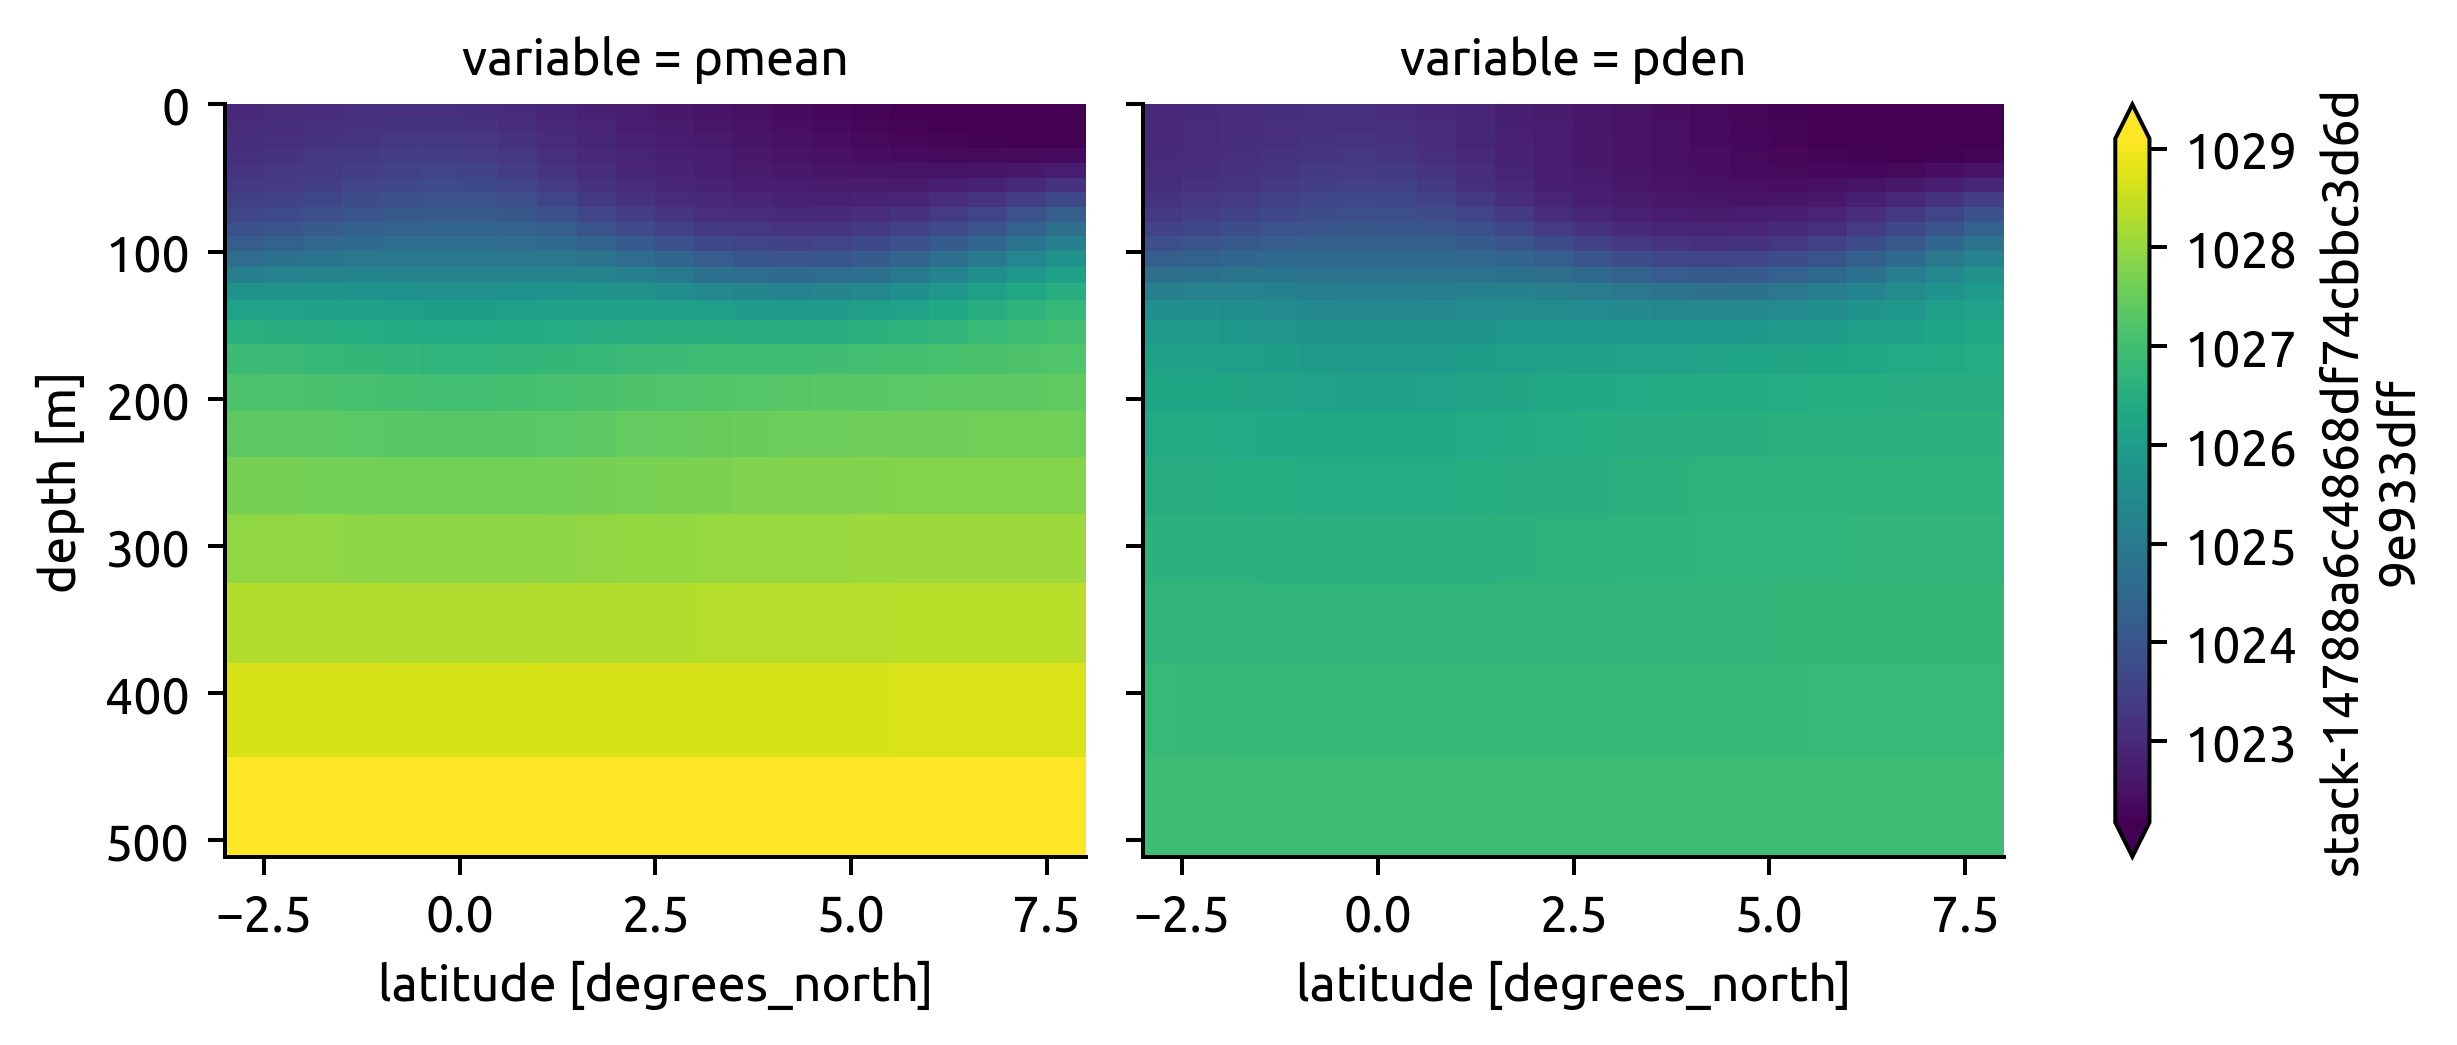

In [8]:
(
    ecco[["ρmean", "pden"]]
    # .sel(lon=220, method="nearest")
    .to_array().cf.plot(col="variable", y="vertical", robust=True)
)

---

## Estimate gradients


In [14]:
bins = np.array([1023.2, 1023.5, 1024, 1025, 1026])
centers = (bins[1:] + bins[:-1]) / 2
ic.ic(bins, centers)

ic| bins: array([1023.2, 1023.5, 1024. , 1025. , 1026. ])
    centers: array([1023.35, 1023.75, 1024.5 , 1025.5 ])


(array([1023.2, 1023.5, 1024. , 1025. , 1026. ]),
 array([1023.35, 1023.75, 1024.5 , 1025.5 ]))

/home/deepak/work/python/dcpy/dcpy/plots.py:1006: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax = cs.ax


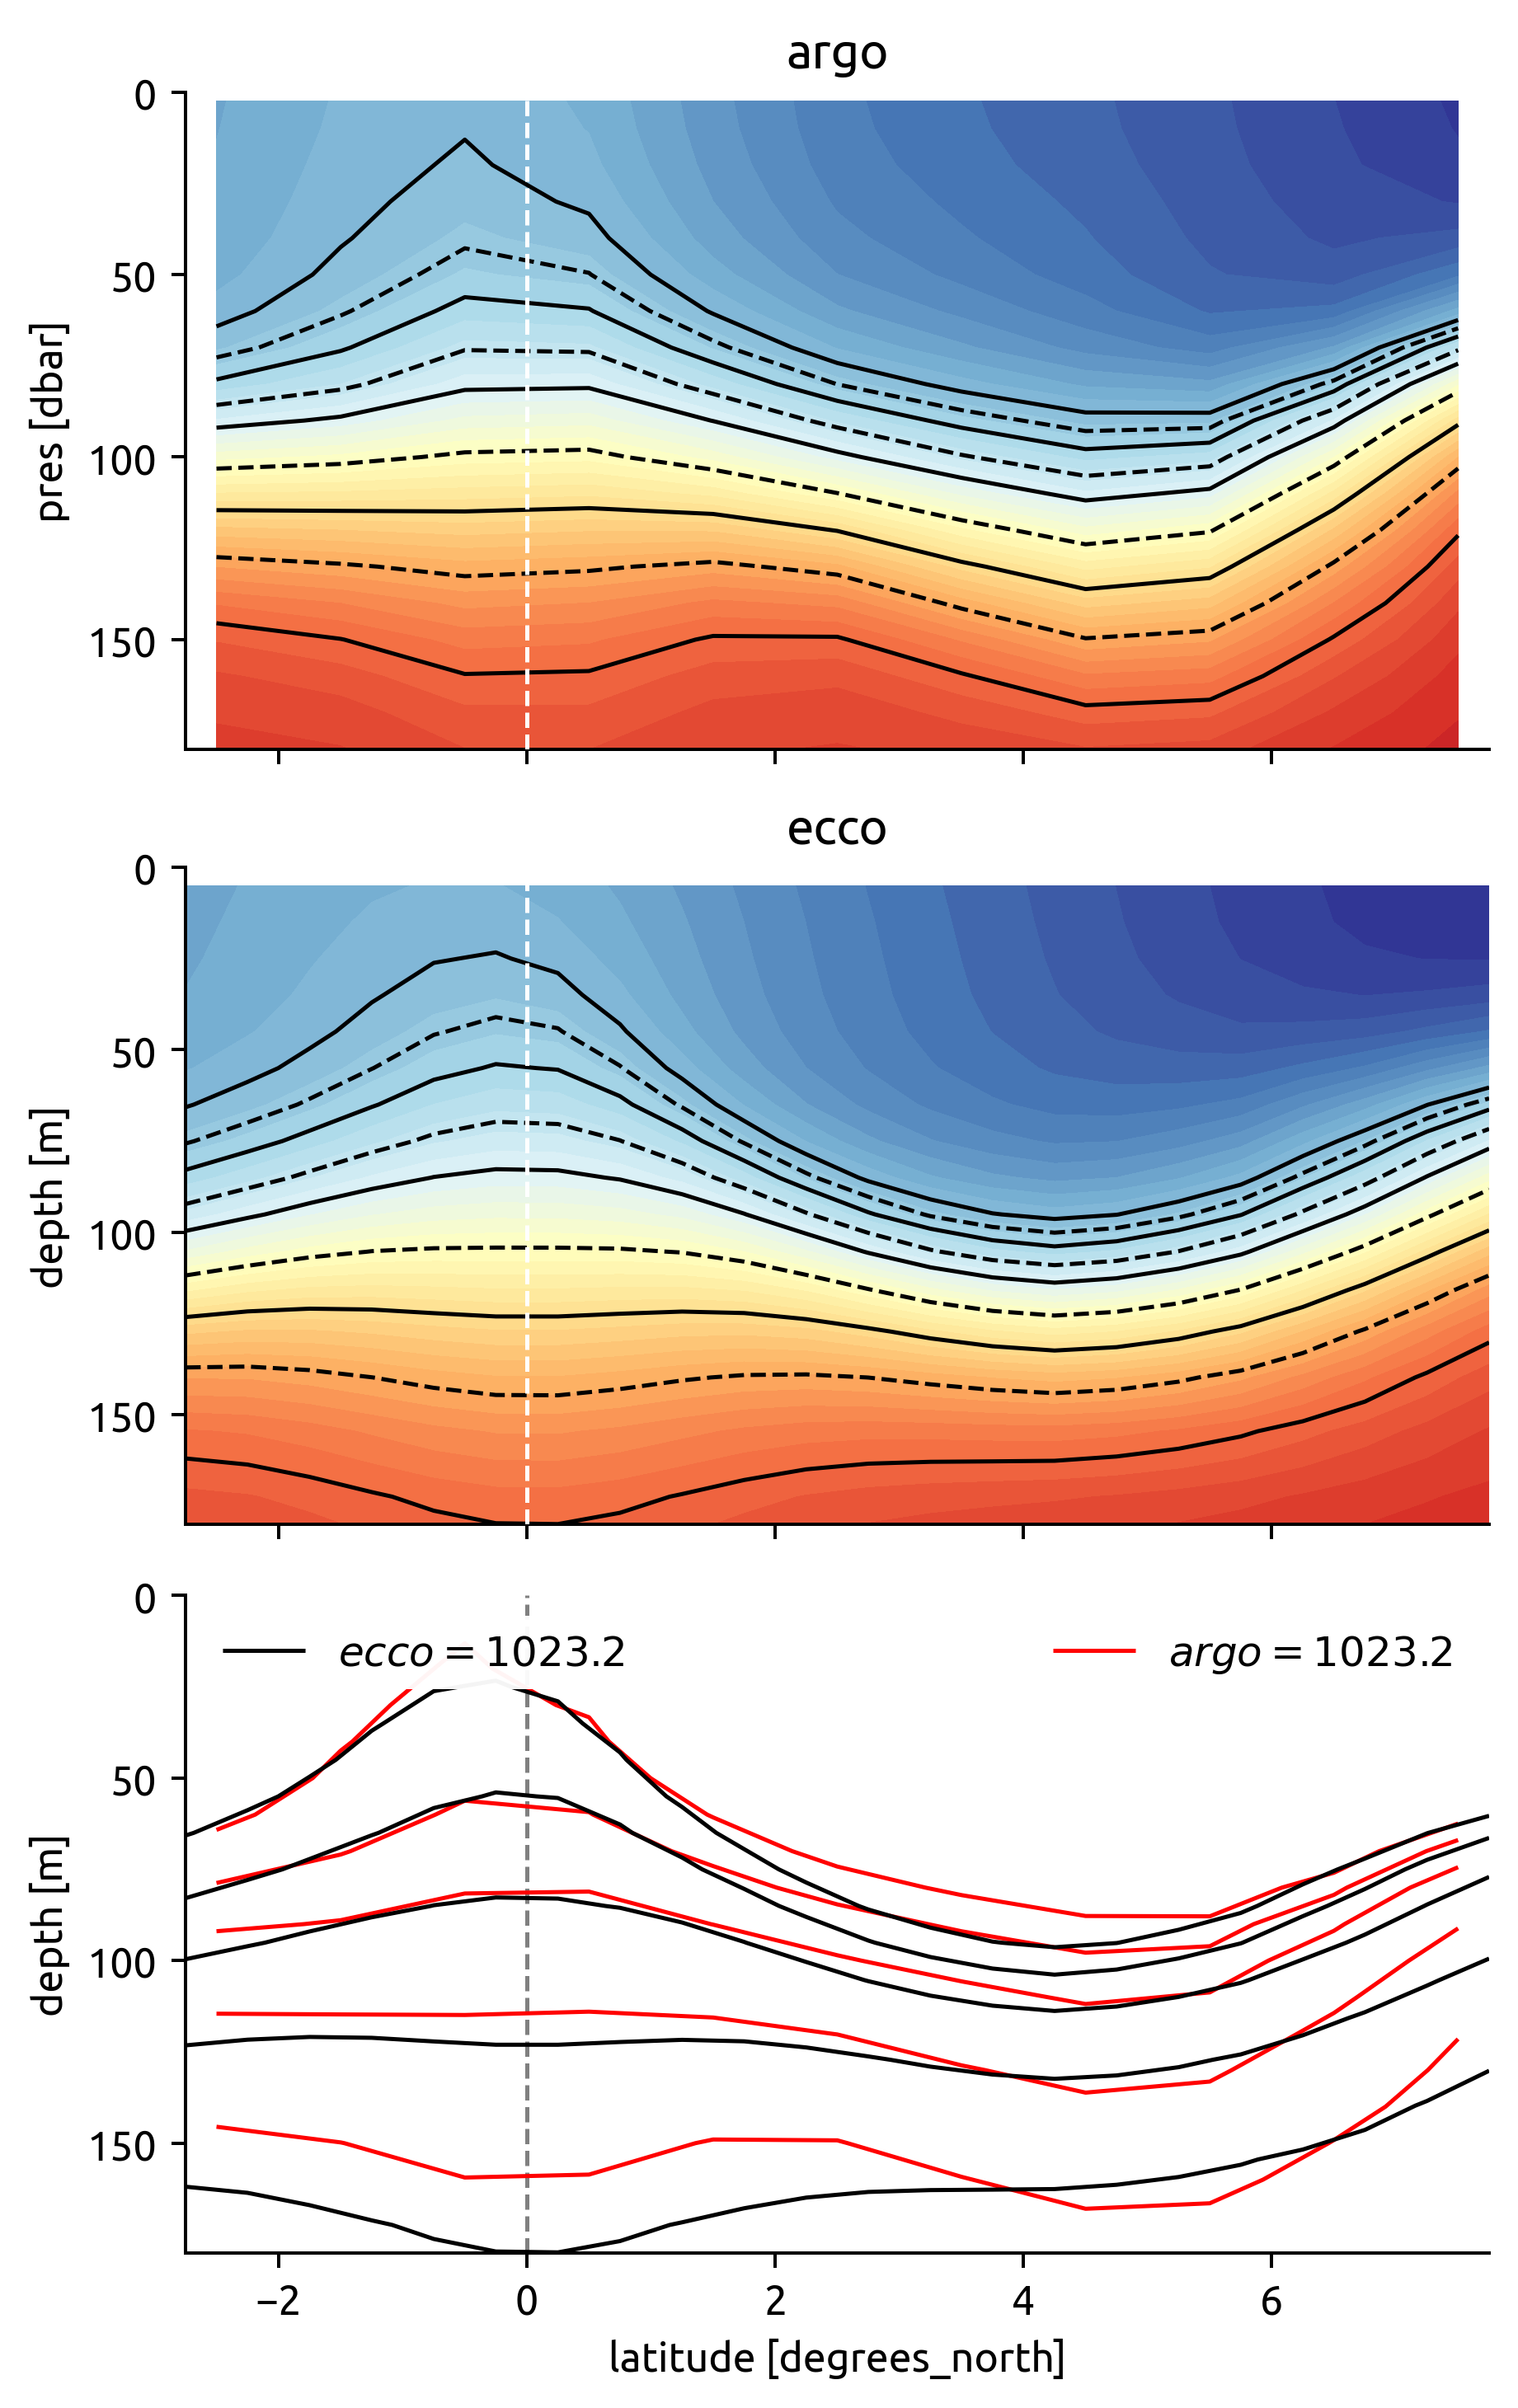

In [15]:
ed.plot.check_bins_with_climatology(bins, argo, ecco)

The magnitudes of ∂T/∂y seem to agree to within a factor of 2. Though the latitudinal profile of these gradients looks quite different (argo vs ecco)

The spline fits to the Argo data seems a little "stiff". Maybe I need to play with some parameters

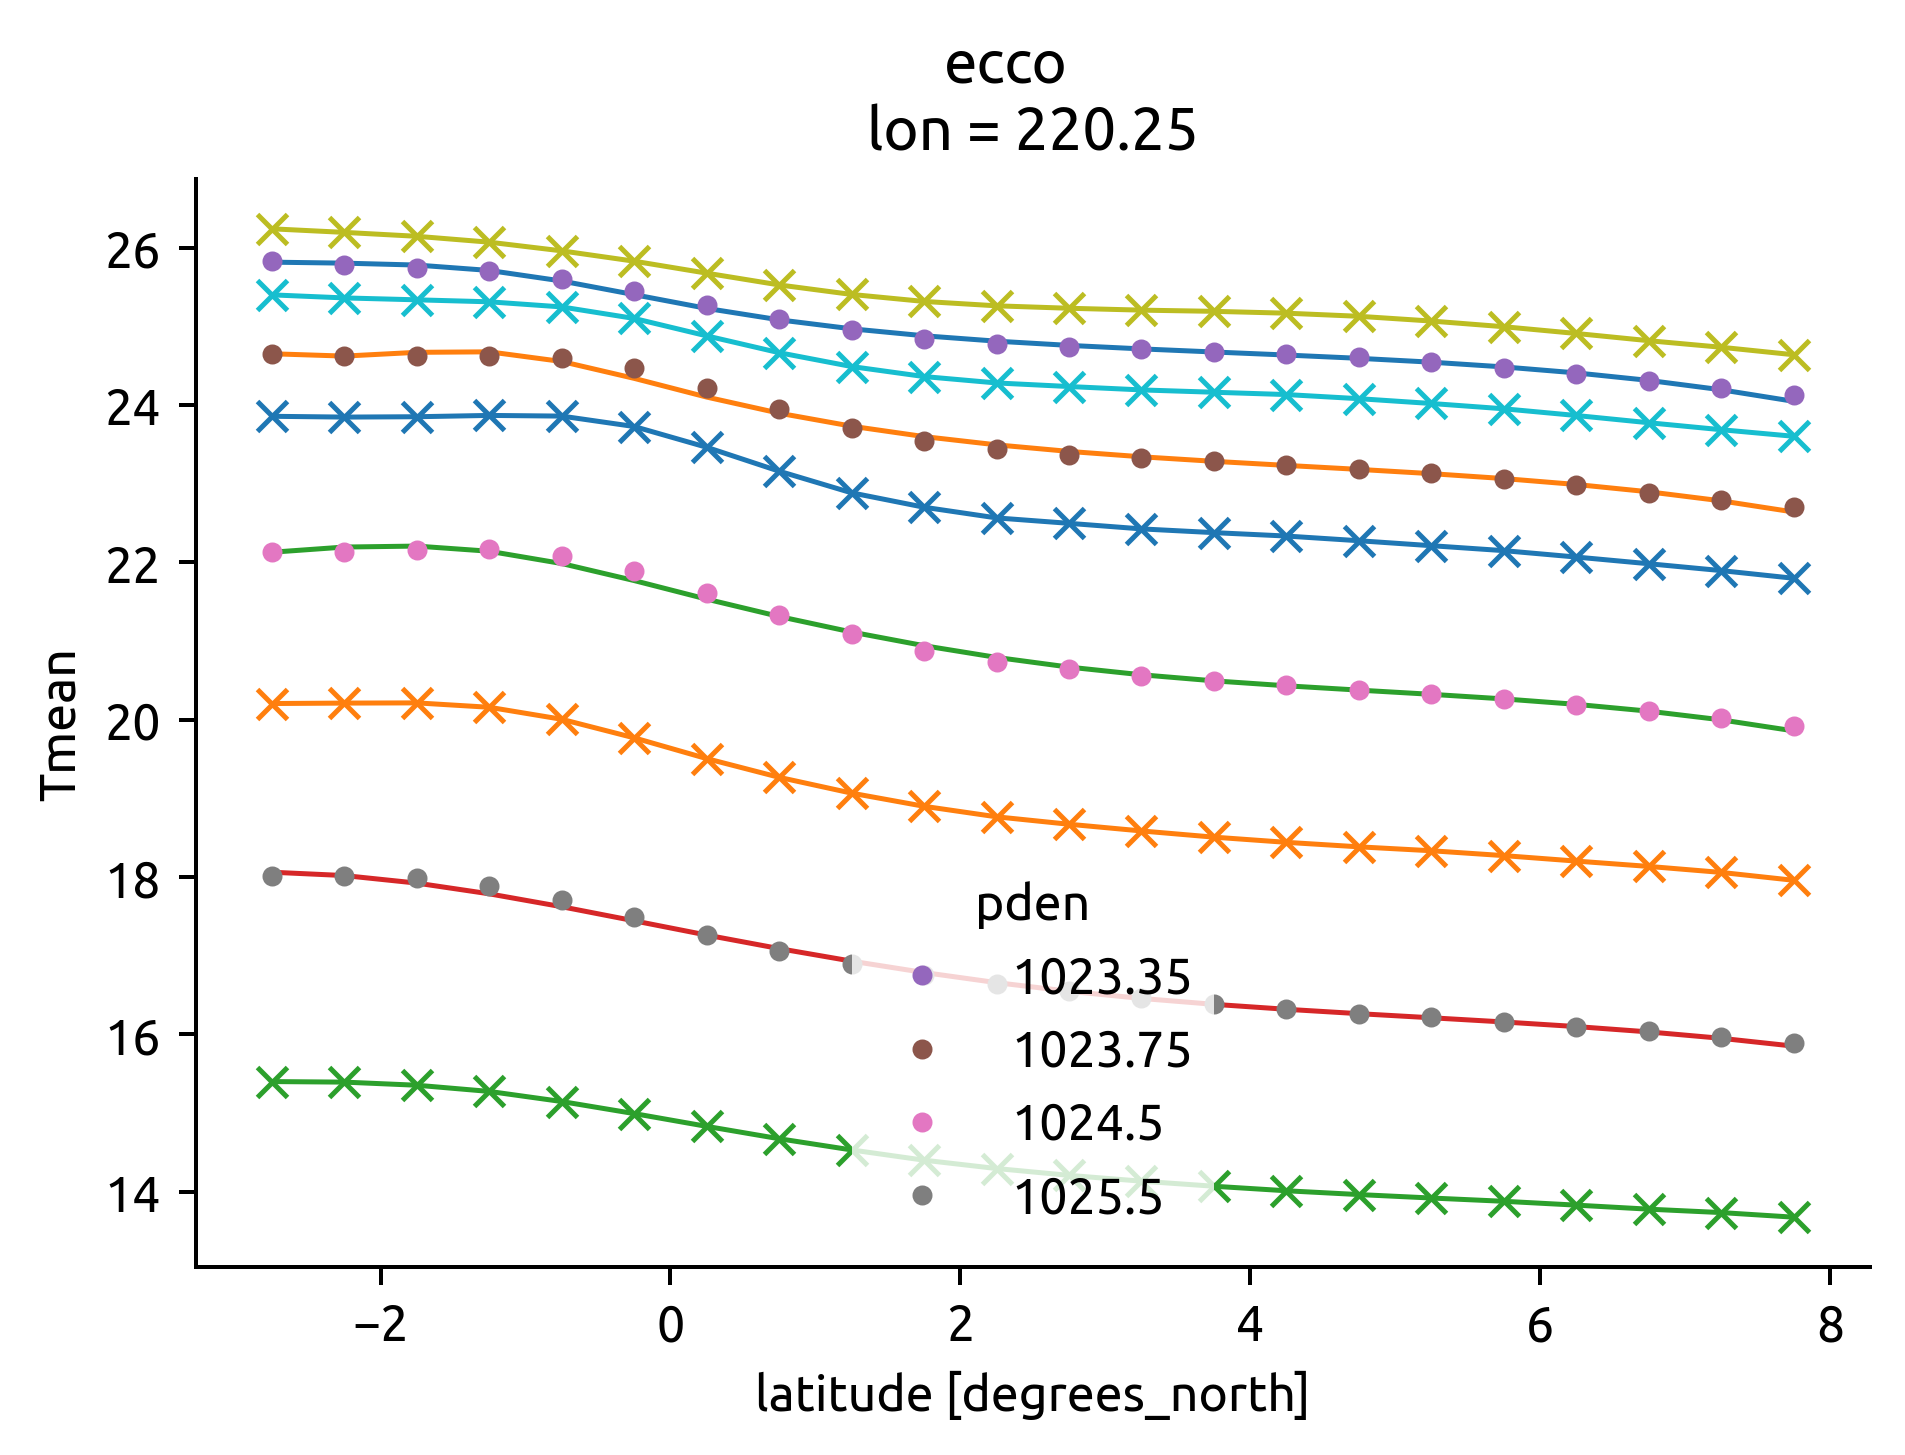

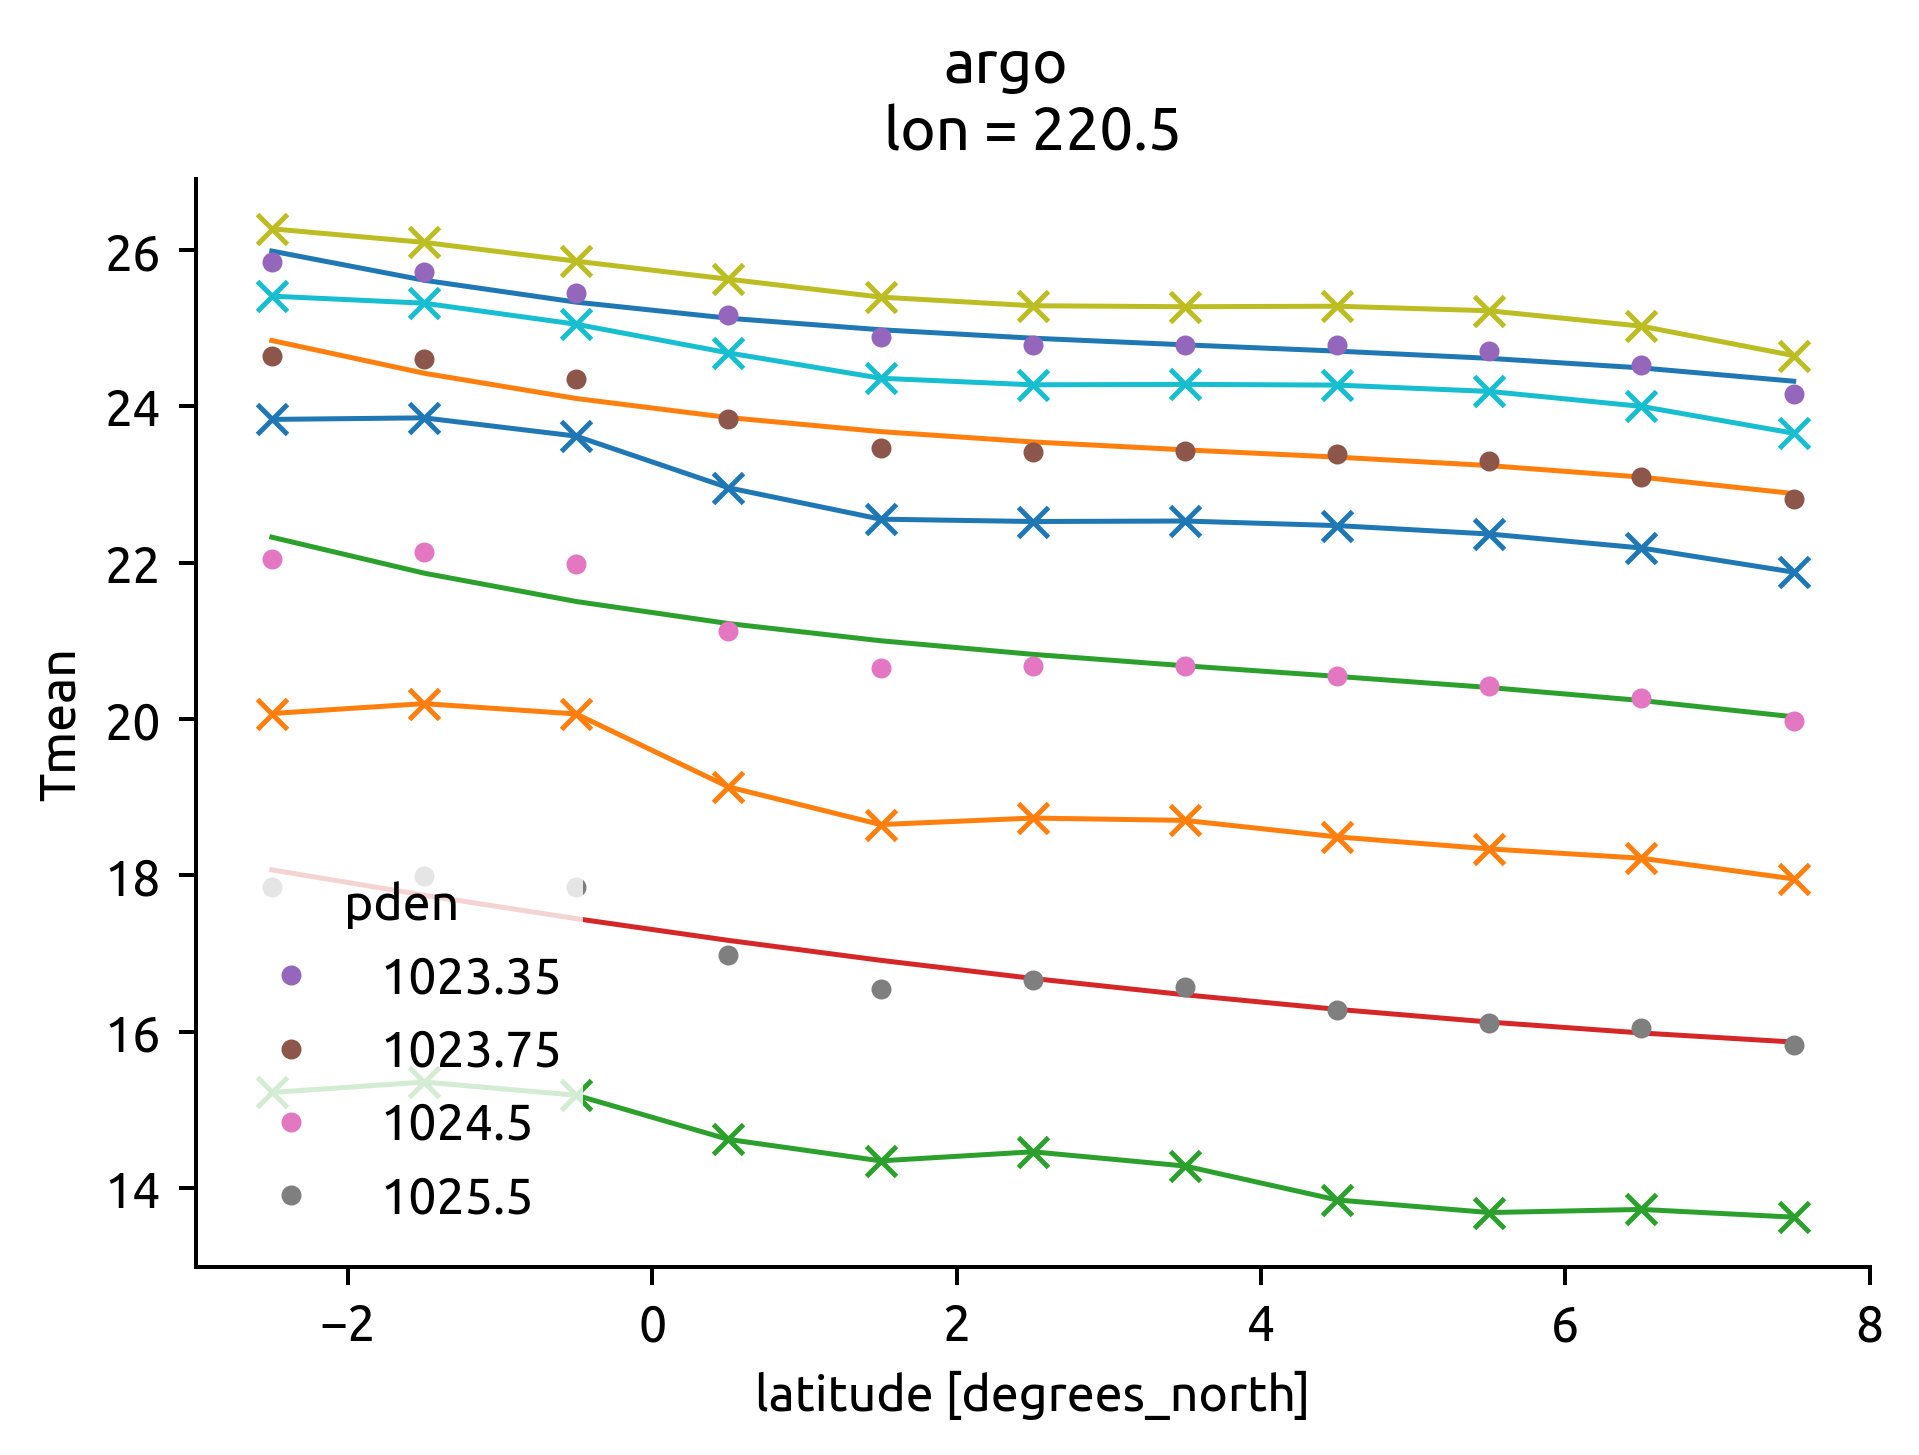

In [39]:
eccoT, edge = ed.eddydiff.estimate_gradients(ecco, bins, debug=True)
argoT, edge = ed.eddydiff.estimate_gradients(argo, bins, debug=True)

---
### Compare horizontal gradient

<Figure size 1080x720 with 0 Axes>

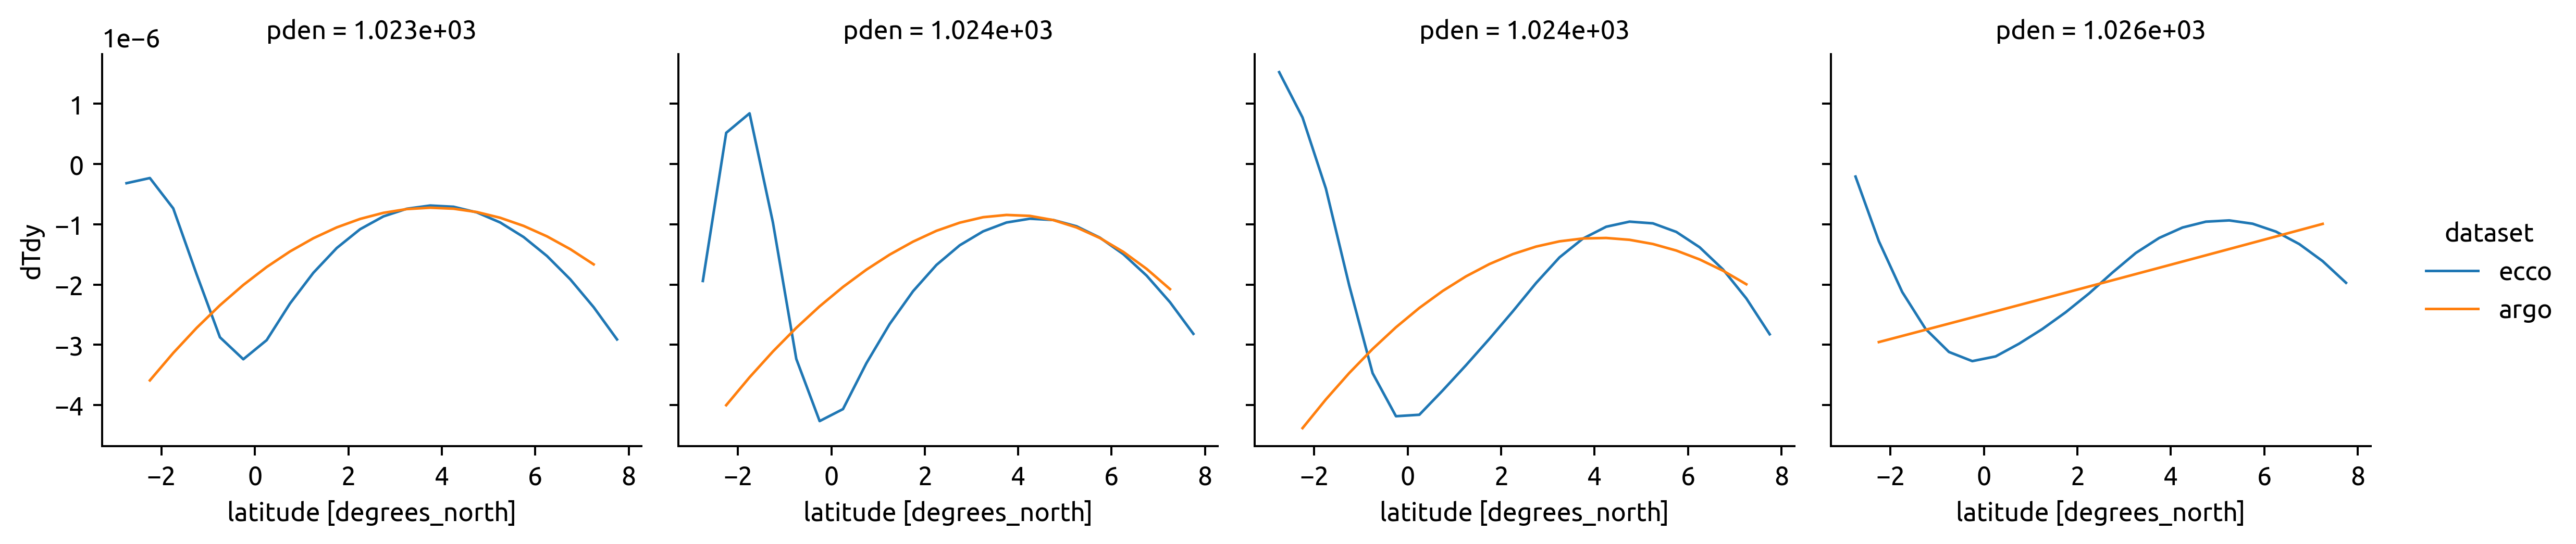

In [40]:
plt.figure()
xr.concat([eccoT.dTdy, argoT.dTdy.interp(lat=eccoT.lat)], dim=["ecco", "argo"]).rename(
    {"concat_dim": "dataset"}
).plot.line(x="lat", col="pden", hue="dataset")

---

### Compare vertical gradient


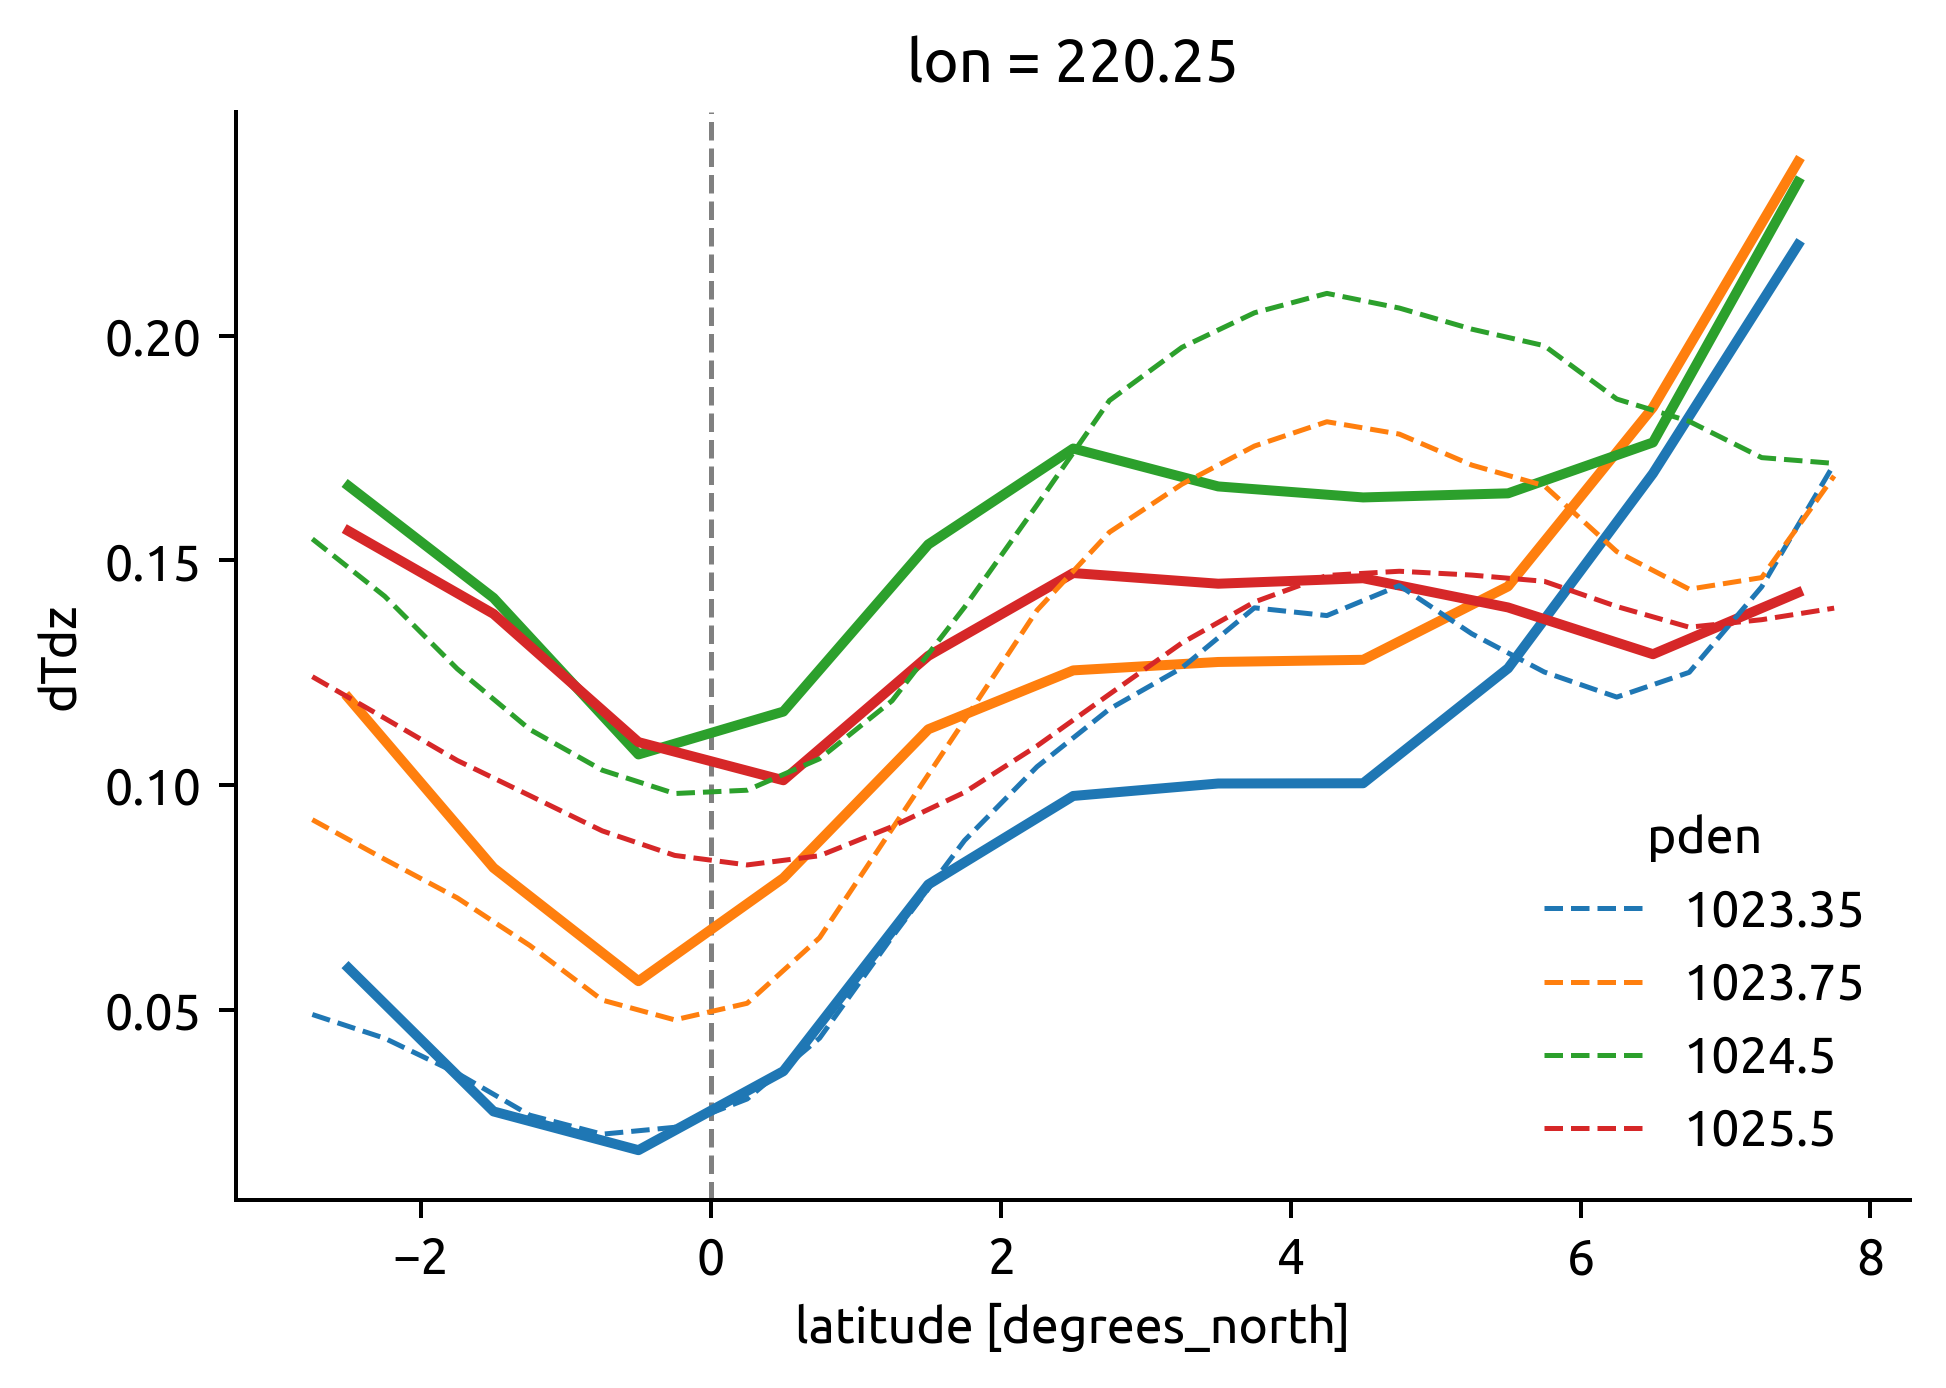

In [41]:
plt.rcParams["figure.dpi"] = 180

from cycler import cycler

cycle = plt.rcParams["axes.prop_cycle"]
with plt.rc_context({"axes.prop_cycle": cycler(color=cycle[:4])}):
    argoT.dTdz.plot.line(x="lat", lw=2)
    eccoT.dTdz.plot.line(x="lat", ls="--")
    dcpy.plots.linex(0)

### debugging plots

In [11]:
ed.fit_spline(isoT.lat, isoT.Tmean.isel(ρmean_bins=10).values, debug=True)

NameError: name 'isoT' is not defined

In [ ]:
eccograd.Tmean.sel(lon=slice(200, 240), lat=slice(-10, 10), pres=slice(150)).sel(
    lon=220, lat=0, method="nearest"
).plot(x="time", ylim=(200, 0), robust=True)
eccograd.ρmean.sel(lon=slice(200, 240), lat=slice(-10, 10), pres=slice(150)).sel(
    lon=220, lat=0, method="nearest"
).plot.contour(levels=11, x="time", ylim=(200, 0), robust=True)

In [ ]:
eccograd.dTdz.sel(lat=slice(-10, 10), lon=slice(200, 240)).sel(
    pres=100, method="nearest"
).isel(time=0).plot()

In [ ]:
eccograd.dTiso.sel(lat=slice(-10, 10), lon=slice(200, 240)).sel(
    pres=100, method="nearest"
).isel(time=0).plot()